In [1]:
# preamble
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run lib/preamble.py

Using TensorFlow backend.


# Models

In [2]:
!cat lib/models.py

import clgen
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import sys
import time

from clgen import clutil
from clgen.atomizer import CharacterAtomizer, GreedyAtomizer

from collections import defaultdict, Counter

from keras.layers import Input, Dropout, Embedding, merge, LSTM, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.visualize_util import model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier

from scipy.stats import percentileofscore
from scipy.stats.mstats import gmean
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier


def cgo13():
    def create_model(seed=None, **kwargs)

### Model description

In [3]:
%run lib/models.py
d = load_data_desc("amd", source="B", max_seq_len=1024, atomizer=CharacterAtomizer)
m = harry()["create_model"](data_desc=d)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1024


In [4]:
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
code_in (InputLayer)             (None, 1024)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1024, 64)      5376        code_in[0][0]                    
____________________________________________________________________________________________________
data_in (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 16)            5184        embedding_1[0][0]                
___________________________________________________________________________________________

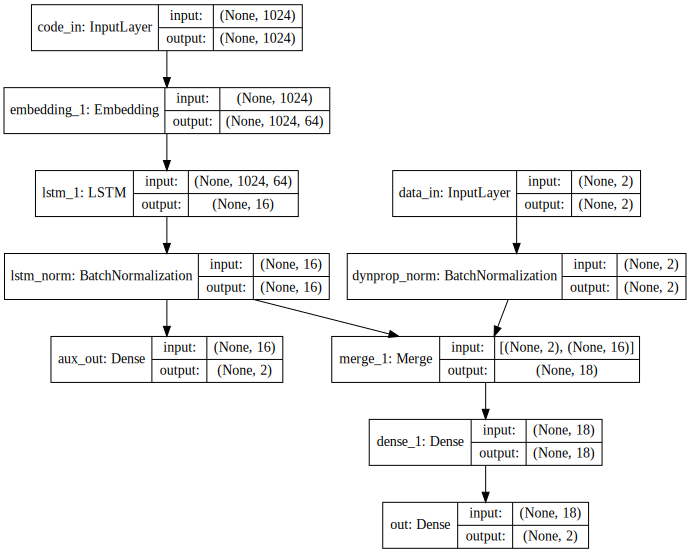

In [5]:
SVG(model_to_dot(m, show_shapes=True).create(prog='dot', format='svg'))

# Evaluate

In [48]:
from itertools import product

def source2str(s):
    if s == "B":
        return "Benchmarks"
    elif s == "S":
        return "CLgen"
    elif s == "BS":
        return "w. CLgen"
    else:
        raise Exception
        
def model2str(m):
    if m == "zero_r":
        return "Static mapping"
    elif m == "cgo13":
        return "CGO'13"
    elif m == "karl":
        return "DeepTune"
    else:
        return m.title()

### Load Data

In [51]:
%run lib/preamble.py
%run lib/models.py

models = ["zero_r", "cgo13", "harry", "karl", "rupert", "sally"]
platforms = ["amd", "nvidia"]
sources = ["B"]#, "BS"]
atomizers = ["GreedyAtomizer"]#, "CharacterAtomizer"]
n_splits = 10
splits = range(n_splits)
seed = 204

data = None

for model, platform, source, atomizer, split_i in product(models, platforms, sources, atomizers, splits):
    result = load_result(globals().get(model)(), platform, source, 
                         atomizer=atomizer, maxlen=1024, seed=seed,
                         n_splits=n_splits, split_i=split_i)
    if not result:
        continue
    
    frame = result["dataframe"]
    frame["correct"] = result["correct"]
    frame["acc"] = result["correct"] * 100
    frame["p_speedup"] = result["speedups"]
    frame["p_speedup_perc"] = frame["p_speedup"] * 100
    frame["model"] = [model] * len(frame)
    frame["platform"] = [platform] * len(frame)
    frame["atomizer"] = [atomizer] * len(frame)
    frame["model_name"] = model2str(model)

    if data is None:
        data = frame
    else:
        data = pd.concat((data, frame))
        
model_names = sorted(set(data["model_name"]))
suite_names = sorted(set(data["source"]))
benchmark_names = sorted(set(data["benchmark_name"]))

d = data.copy()

# Append aggregate "Average" rows:
for platform, atomizer in product(platforms, atomizers):
    # TODO: source B, BS
    msk = (data["platform"] == platform) & (data["atomizer"] == atomizer)
    r = data[msk].groupby('model_name').mean()
    r["source"] = ["Average"] * len(r)
    r["platform"] = [platform] * len(r)
    r["atomizer"] = [atomizer] * len(r)
    r["model_name"] = model_names
    d = d.append(r)

assert(len(d[d["source"] == "Average"]) == len(list(product(platforms, sources, atomizers))) * len(model_names))
data

,benchmark,dataset,comp,rational,mem,localmem,coalesced,atomic,transfer,wgsize,...,seq_len,seq,correct,acc,p_speedup,p_speedup_perc,model,platform,atomizer,model_name
9,amd-app-sdk-3.0-ScanLargeArrays-ScanLargeArrays,default,32,3,21,14,4,0,263168,128,...,513,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,0.505803,50.580324,zero_r,amd,GreedyAtomizer,Static mapping
11,amd-app-sdk-3.0-ScanLargeArrays-prefixSum,default,31,3,19,13,3,0,263168,64,...,486,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,0.701699,70.169912,zero_r,amd,GreedyAtomizer,Static mapping
25,npb-3.3-BT-compute_rhs2,B,27,4,2,0,2,0,1313675032,32,...,375,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",False,0,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping
26,npb-3.3-BT-compute_rhs2,S,27,4,2,0,2,0,1807992,60,...,375,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,0.790205,79.020479,zero_r,amd,GreedyAtomizer,Static mapping
27,npb-3.3-BT-compute_rhs2,W,27,4,2,0,2,0,15948384,48,...,375,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping
36,npb-3.3-BT-compute_rhs5,A,1260,23,8,0,87,0,320457304,62,...,14289,"[1, 113, 51, 18, 52, 8, 1, 10, 1, 7, 7, 7, 15,...",False,0,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping
42,npb-3.3-BT-compute_rhs6,S,16,4,1,0,2,0,1807992,60,...,308,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping
55,npb-3.3-BT-exact_rhs2,W,340,26,5,0,112,0,15948384,44,...,4072,"[8, 8, 1, 9, 1, 7, 20, 13, 15, 1, 9, 1, 123, 5...",True,100,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping
69,npb-3.3-BT-initialize1,B,12,4,1,0,1,0,1313675032,32,...,273,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",False,0,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping
74,npb-3.3-BT-initialize2,S,116,10,7,0,40,0,1807992,60,...,789,"[129, 129, 129, 129, 129, 129, 129, 129, 129, ...",True,100,1.000000,100.000000,zero_r,amd,GreedyAtomizer,Static mapping


In [52]:
# print model accuracy and speedup (per-platform)
amd_msk = (data["platform"] == "amd") & (data["atomizer"] == "GreedyAtomizer")
nvidia_msk = (data["platform"] == "nvidia") & (data["atomizer"] == "GreedyAtomizer")

print(data[["model_name", "source", "acc", "p_speedup"]].groupby("model_name").mean())
print("\nAMD:")
print(data[amd_msk][["model_name", "source", "acc", "p_speedup"]].groupby("model_name").mean())
print("\nNVIDIA:")
print(data[nvidia_msk][["model_name", "source", "acc", "p_speedup"]].groupby("model_name").mean())

                      acc  p_speedup
model_name                          
CGO'13          73.161765   0.734061
DeepTune        82.285714   0.734132
Harry           82.612245   0.739932
Rupert          63.455882   0.769345
Sally           82.113821   0.746191
Static mapping  57.867647   0.788421

AMD:
                      acc  p_speedup
model_name                          
CGO'13          73.382353   0.705625
DeepTune        86.274510   0.716198
Harry           85.947712   0.732493
Rupert          69.411765   0.728865
Sally           82.647059   0.749327
Static mapping  58.823529   0.764933

NVIDIA:
                      acc  p_speedup
model_name                          
CGO'13          72.941176   0.762496
DeepTune        78.303426   0.752037
Harry           79.282219   0.747359
Rupert          57.500000   0.809825
Sally           81.454545   0.742312
Static mapping  56.911765   0.811910


In [58]:
order = ["AMD", "NPB", "NVIDIA", "Parboil", "Polybench", "Rodinia", "SHOC", "Average"]

def plot_ex1_graph(x="source", y="acc", hue="model_name", order=order, n_palette=len(model_names),
                   data=data, atomizer="CharacterAtomizer", ylabel="Accuracy (%)", ci=None):
    palette = sns.cubehelix_palette(n_palette, rot=1.8, light=.85, dark=.35)

    for i, platform in enumerate(["amd", "nvidia"]):
        plt.subplot(2, 1, i + 1)
        msk = (data["platform"] == platform) & (data["atomizer"] == atomizer)
        ax = sns.barplot(x=x, y=y, hue=hue, order=order, palette=palette,
                         data=data[msk],
                         ci=ci, errwidth=1, capsize=.08)

        plt.ylim((0, 100))
        plt.ylabel(ylabel)
        plt.xlabel("")
        
        # vertical divider for "Average" column
        plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")
        
        # legend
        plt.legend(loc='upper left', bbox_to_anchor=(1,1))
        ax.get_legend().set_title("")  # no legend title
        ax.get_legend().draw_frame(True)
        
#         plt.title("{platform} Platform".format(platform=platform.upper()))
#         viz.finalise(figsize=(9,2.7))
        viz.finalise(figsize=(9,2.6))

### Accuracy

Atomizer: GreedyAtomizer


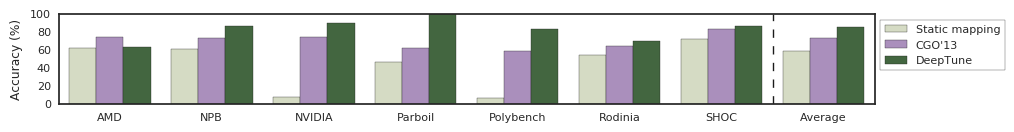

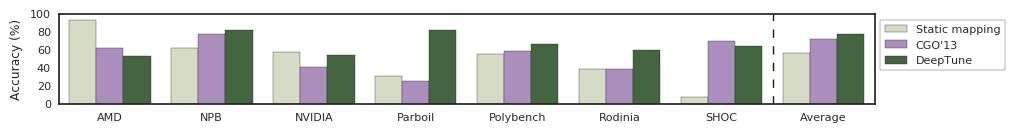

In [59]:
_d = d[(d["model_name"] == "Static mapping") | (d["model_name"] == "CGO'13") | (d["model_name"] == "DeepTune")]
for atomizer in atomizers:
    print("Atomizer:", atomizer)
    plot_ex1_graph(x="source", order=suite_names + ["Average"], y="acc", data=_d, n_palette=3, atomizer=atomizer)

### Performance (% optimal)

Atomizer: GreedyAtomizer


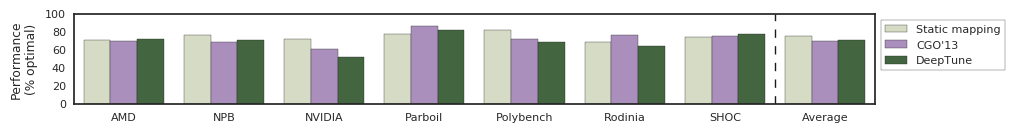

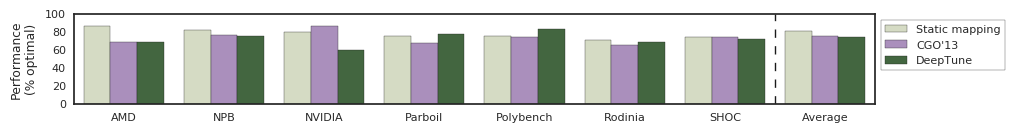

In [60]:
for atomizer in atomizers:
    print("Atomizer:", atomizer)
    plot_ex1_graph(x="source", order=suite_names + ["Average"], y="p_speedup_perc", 
                   data=_d, n_palette=3, atomizer=atomizer, ylabel="Performance\n(% optimal)")